# MNIST Digit Classifier

In [1]:
# This cell assumes a project structure of: project-root/src/experiments/this_notebook.ipynb
# We append the parent directory to the system path, so now we can import modules from src
# We also create a variable named path which points to the project root.

import sys
from pathlib import Path

sys.path.append("../") # go to parent dir
path =  str(Path().resolve().parent.parent)

print(path)


/data2/Kaggle-Knowledge-Competitions


First run the training script and generate the predictions. Note: this MNIST classifier does not take long to train, so I am happy to re train it if I want more predictions. For bigger models, it is a good idea to train the model using the CLI and save the checkpointed model. It is also useful to use the CLI for prototyping, because it uses Weights and Biases to log metrics. We only calculate minimal metrics here because I already know that this configuration works.

In [6]:
import pytorch_lightning as pl

from models.mnist_classifier import MNISTClassifierModule
from datasets.kaggle_mnist import KaggleMNISTDataModule

model = MNISTClassifierModule(learning_rate=0.01)
data = KaggleMNISTDataModule(data_dir=path+"/data/kaggle_mnist",batch_size=128)

trainer = pl.Trainer(max_epochs=5, gpus=1, precision=16, logger=False, checkpoint_callback=False)
trainer.fit(model, data)

data.setup()
raw_test_predictions = trainer.predict(model, data.test_dataloader())


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | net  | ResNet50 | 23.5 M
----------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.089    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/data2/Kaggle-Knowledge-Competitions/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 263it [00:00, ?it/s]

Our raw prediction is currently a list of tuples representing the predictions for each batch. We want to turn this into two tensors, each the length of the test set.

In [10]:
import torch

def unpack_predictions(predictions):
    """Takes the output of trainer.predict and unpacks it into a tuple of two tensors
    over the data set:
        (imgs, predictions)
    """
    # predictions start as list of tuples (prediction tensor, label tensor, colour tensor), of length num_batches.
    # each tensor is 1D with length batch_size.
    # we want to convert this to two tensors which are the length of the val/test set.
    unpacked_imgs = torch.Tensor().to(predictions[0][0].device)
    unpacked_predictions = torch.Tensor().to(predictions[0][0].device)
    for batch in predictions:
        imgs, preds = batch
        unpacked_predictions = torch.cat([unpacked_predictions, preds], dim=0)
        unpacked_imgs = torch.cat([unpacked_imgs, imgs], dim=0)

    return  unpacked_imgs, unpacked_predictions

predictions = unpack_predictions(raw_test_predictions)

Now, lets sanity check our predictions to see if they're reasonable:

6
7
2
4
2
0
7
2
4
5


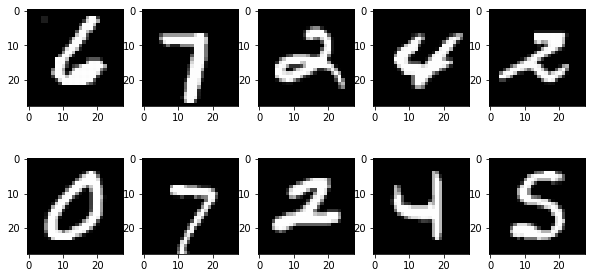

In [21]:
import matplotlib.pyplot as plt
import random

imgs, preds = predictions
imgs = imgs.squeeze().detach().cpu().numpy()
preds = preds.int().squeeze().detach().cpu().numpy()

nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10,5))

for i in range(nrows):
    for j in range(ncols):
        k = random.randint(0,28000)
        axs[i,j].imshow(imgs[k],cmap="gray")
        print(preds[k])


Finally, save our predictions in the format for Kaggle submission. You can submit by running the following line:
```bash
# submits preds.csv to the mnist classification competition
kaggle competitions submit -c digit-recognizer -f data/kaggle_mnist/preds.csv --message first_submission_with_api

In [23]:
import pandas as pd
df = pd.DataFrame({"ImageId" : list(range(1, 28001)),"Label" : preds})
df.to_csv(path+"/data/kaggle_mnist/preds.csv", index=False)